## NREL National Solar Radiation Database (NSRDB) - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = CLN7qg8PRpaqkkeS9STW3BvCMvh81m4UYopmVoOf
```

You can also add the above contents to a configuration file at ~/.hscfg

In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Basic Usage

The NSRDB is provided in annual .h5 files and currently spans 1998-2018.  
Each year can be accessed from /nrel/nsrdb/nsrdb_${year}.h5

In [56]:
# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2020.h5", 'r')

In [58]:
list(f.attrs)  # list attributes belonging to the root group

['version']

In [60]:
f.attrs['version']   # attributes can be used to provide desriptions of the content

'3.2.0'

In [61]:
list(f['wind_speed'].attrs)

['data_source',
 'elevation_correction',
 'physical_max',
 'physical_min',
 'psm_scale_factor',
 'psm_units',
 'scale_factor',
 'spatial_interp_method',
 'temporal_interp_method',
 'units']

## Datasets

In [62]:
list(f)  # list the datasets in the file

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_press_acha',
 'cloud_type',
 'coordinates',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [63]:
# Datasets are stored in a 2d array of time x location
dset = f['ghi']
dset.shape

(17568, 2018392)

In [64]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-01 00:30:00+00:00',
               '2020-01-01 01:00:00+00:00', '2020-01-01 01:30:00+00:00',
               '2020-01-01 02:00:00+00:00', '2020-01-01 02:30:00+00:00',
               '2020-01-01 03:00:00+00:00', '2020-01-01 03:30:00+00:00',
               '2020-01-01 04:00:00+00:00', '2020-01-01 04:30:00+00:00',
               ...
               '2020-12-31 19:00:00+00:00', '2020-12-31 19:30:00+00:00',
               '2020-12-31 20:00:00+00:00', '2020-12-31 20:30:00+00:00',
               '2020-12-31 21:00:00+00:00', '2020-12-31 21:30:00+00:00',
               '2020-12-31 22:00:00+00:00', '2020-12-31 22:30:00+00:00',
               '2020-12-31 23:00:00+00:00', '2020-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17568, freq=None)

In [65]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,b'None',b'None',b'None',b'None',-9999,210
1,-19.99,-175.220001,0.0,13,b'None',b'None',b'None',b'None',-9999,210
2,-19.99,-175.179993,0.0,13,b'None',b'None',b'None',b'None',-9999,210
3,-19.99,-175.139999,0.0,13,b'None',b'None',b'None',b'None',-9999,210
4,-19.99,-175.100006,0.0,13,b'None',b'None',b'None',b'None',-9999,210


In [66]:
meta[meta.state == b'PRI-00 (Puerto Rico aggregatio']

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
1440562,18.090000,-67.900002,66.000000,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',0,120
1441326,18.090000,-67.860001,48.250000,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',3,20
1459759,18.370001,-67.220001,18.684210,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',5454,30
1460550,18.330000,-67.220001,74.949997,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',5684,30
1460837,18.330000,-67.180000,159.199997,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',7397,30
...,...,...,...,...,...,...,...,...,...,...
1512413,18.129999,-65.459999,55.882355,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',4533,30
1514045,18.129999,-65.419998,55.799999,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',2055,40
1515288,18.129999,-65.379997,33.200001,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',35,40
1516882,18.129999,-65.339996,26.176470,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',0,210


In [67]:
# Datasets have been saved as integers
dset.dtype

dtype('uint16')

In [68]:
dset.shape[0] * dset.shape[1] * 2 * 10**-9 # 70 GB per dataset!

70.918221312

In [69]:
dset.chunks # Chunked by week

(2688, 372)

In [70]:
dset.chunks[0] * dset.chunks[1] * 2 * 10**-6 # 2 MB per chunk

1.9998719999999999

In [71]:
# To convert dataset values back to floats use the 'psm_scale_factor'
dset.attrs['psm_scale_factor'] # Irradiance values have been truncated to integer precision

1.0

In [72]:
# wind speed on the other hand has single decimal percision when scaled by 10
scale_factor = f['wind_speed'].attrs['psm_scale_factor']
units = f['wind_speed'].attrs['psm_units']
print('wind_speed scale factor = ', scale_factor)
# print('wind_speed units after unscaling = ', units)
f['wind_speed'][0, 0] / scale_factor # divide by scale_factor to return native value

wind_speed scale factor =  10.0


9.7

## Time-slicing

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [73]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2020-01-01 00:00:00+00:00', '2020-01-01 00:30:00+00:00',
               '2020-01-01 01:00:00+00:00', '2020-01-01 01:30:00+00:00',
               '2020-01-01 02:00:00+00:00', '2020-01-01 02:30:00+00:00',
               '2020-01-01 03:00:00+00:00', '2020-01-01 03:30:00+00:00',
               '2020-01-01 04:00:00+00:00', '2020-01-01 04:30:00+00:00',
               ...
               '2020-12-31 19:00:00+00:00', '2020-12-31 19:30:00+00:00',
               '2020-12-31 20:00:00+00:00', '2020-12-31 20:30:00+00:00',
               '2020-12-31 21:00:00+00:00', '2020-12-31 21:30:00+00:00',
               '2020-12-31 22:00:00+00:00', '2020-12-31 22:30:00+00:00',
               '2020-12-31 23:00:00+00:00', '2020-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17568, freq=None)

Extract indexes for a particular span of time:

In [74]:
march = time_index.month == 3
np.where(march)[0]

array([2880, 2881, 2882, ..., 4365, 4366, 4367])

Or a particular date:

In [76]:
timestep = np.where(time_index == '2020-07-04 00:00:00')[0][0]
timestep

8880

## Map Data

In [77]:
# Extract coordinates (lat, lon)
print(dict(f['coordinates'].attrs))
coords = f['coordinates'][...]

{'description': '(latitude, longitude)'}


In [26]:
dset = f['ghi']
%time data = dset[timestep, ::10]   # extract every 10th location at a particular time
df = pd.DataFrame() # Combine data with coordinates in a DataFrame
df['longitude'] = coords[::10, 1]
df['latitude'] = coords[::10, 0]
df['ghi'] = data / dset.attrs['psm_scale_factor'] # unscale dataset

CPU times: user 10.8 ms, sys: 1.03 ms, total: 11.8 ms
Wall time: 38.6 s


In [27]:
df.shape

(201840, 3)

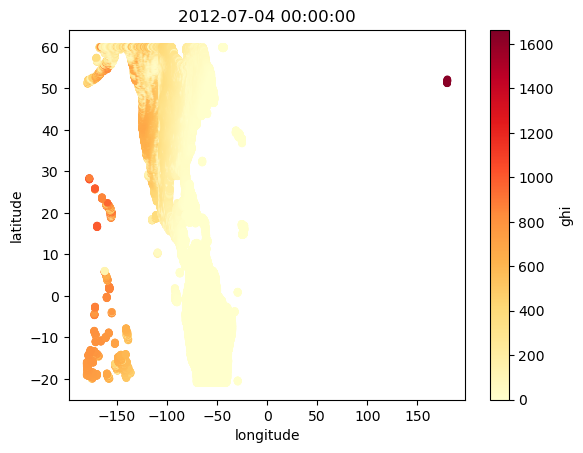

In [28]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [29]:
# Full resolution subset of Colorado
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
70276,32.529999,-117.099998,55.062500,-8,b'United States',b'California',b'San Diego',b'None',32326,130
70588,32.570000,-117.099998,7.100000,-8,b'United States',b'California',b'San Diego',b'Tijuana',27971,190
70589,32.570000,-117.059998,24.920000,-8,b'United States',b'California',b'San Diego',b'Tijuana',51608,190
70590,32.570000,-117.019997,96.599998,-8,b'United States',b'California',b'San Diego',b'Tijuana',15236,110
70591,32.570000,-116.980003,140.600006,-8,b'United States',b'California',b'San Diego',b'Tijuana',2949,130


In [34]:
len(CA)

26010

In [35]:
data = dset[timestep][CA.index]
len(data)

26010

In [32]:
len(df)

26010

In [33]:
len(dset)

17568

In [36]:
# %time data = dset[timestep][CA.index]  # full-resolution subset
df = CA[['longitude', 'latitude']].copy()
df['ghi'] = data / dset.attrs['psm_scale_factor']
df.shape

(26010, 3)

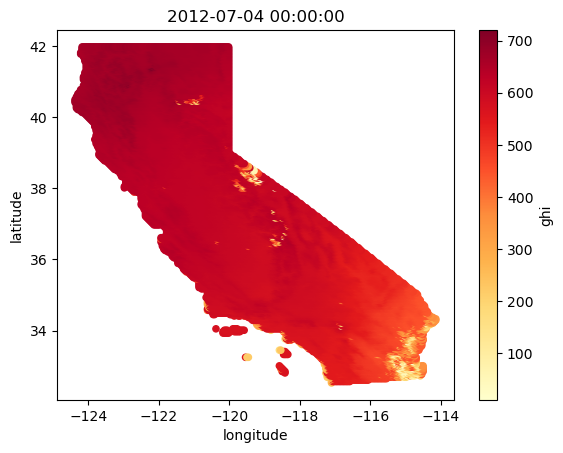

In [37]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [78]:
# Full resolution subset of Colorado
#meta = pd.DataFrame(f['meta'][...])
PR = meta.loc[meta['state'] == b'PRI-00 (Puerto Rico aggregatio'] # Note .h5 saves strings as bit-strings
PR.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
1440562,18.090000,-67.900002,66.000000,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',0,120
1441326,18.090000,-67.860001,48.250000,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'None',3,20
1459759,18.370001,-67.220001,18.684210,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',5454,30
1460550,18.330000,-67.220001,74.949997,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',5684,30
1460837,18.330000,-67.180000,159.199997,-4,b'Puerto Rico',b'PRI-00 (Puerto Rico aggregatio',b'None',b'Mayaguez',7397,30


In [79]:
PR.index

Index([1440562, 1441326, 1459759, 1460550, 1460837, 1460839, 1460857, 1460868,
       1461437, 1461442,
       ...
       1506893, 1507692, 1510343, 1511383, 1511384, 1512413, 1514045, 1515288,
       1516882, 1517812],
      dtype='int64', length=475)

In [80]:
timestep = np.where(time_index == '2020-07-04 00:00:00')[0][0]
timestep

8880

In [81]:
%%time 
data = dset[timestep][PR.index]  # full-resolution subset

CPU times: user 47.6 ms, sys: 0 ns, total: 47.6 ms
Wall time: 38.3 s


In [82]:
df = PR[['longitude', 'latitude']].copy()
df['ghi'] = data / dset.attrs['psm_scale_factor']
df.shape

(475, 3)

In [85]:
df

,longitude,latitude,ghi
1440562,-67.900002,18.090000,0.0
1441326,-67.860001,18.090000,0.0
1459759,-67.220001,18.370001,0.0
1460550,-67.220001,18.330000,0.0
1460837,-67.180000,18.330000,0.0
...,...,...,...
1512413,-65.459999,18.129999,0.0
1514045,-65.419998,18.129999,0.0
1515288,-65.379997,18.129999,0.0
1516882,-65.339996,18.129999,0.0


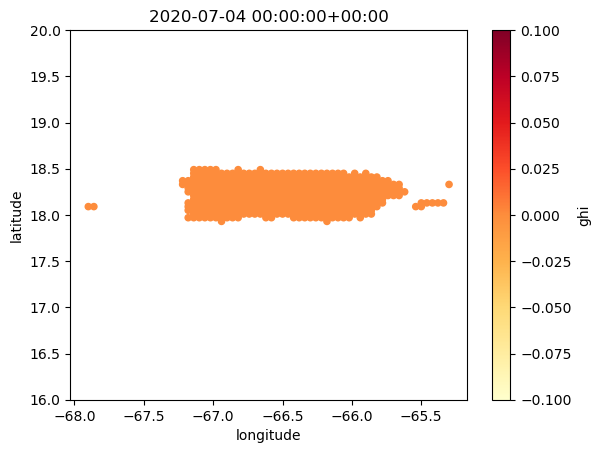

In [84]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.ylim([16,20])
plt.show()

## Nearest Timeseries for given Lat/Lon

In [103]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

dset_coords = f['coordinates'][...]
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1] )

print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(dset_coords[NewYorkCity_idx]))

Site index for New York City: 		 1244690
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 [ 40.73 -74.02]


In [104]:
# Get the entire 2012 timeseries data for a point in NYC
%time tseries = dset[:, NewYorkCity_idx] / dset.attrs['psm_scale_factor']

CPU times: user 2.99 ms, sys: 1.55 ms, total: 4.54 ms
Wall time: 1.55 s


In [105]:
len(tseries)   # 1 years * 365 days * 24 hours * 30 minutes

17568

Text(0.5, 1.0, 'NYC ghi in 2012')

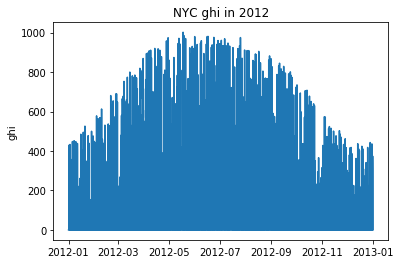

In [107]:
plt.plot(time_index, tseries)
plt.ylabel("ghi")
plt.title("NYC ghi in 2012")

## GHI Statistics

In [108]:
df = pd.DataFrame({'ghi': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="ghi")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,191.806452,290.774194,314.822581,328.016129,299.096774,224.919355,150.903226,48.370968,0.387097,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,280.068966,356.431034,410.603448,429.120690,407.586207,353.517241,230.068966,113.689655,17.482759,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,377.451613,488.935484,528.177419,553.048387,539.645161,462.306452,352.483871,219.112903,81.096774,1.838710
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,568.500000,680.566667,697.900000,685.133333,627.966667,561.566667,422.916667,293.516667,147.283333,25.700000
5,1.580645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,468.274194,563.596774,581.967742,634.758065,616.290323,546.241935,431.596774,325.645161,183.983871,71.096774
6,11.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,602.450000,664.683333,723.700000,677.850000,606.800000,579.633333,468.983333,338.783333,200.316667,92.250000
7,9.048387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,572.790323,699.177419,719.612903,715.532258,646.532258,604.596774,495.548387,370.564516,226.983871,93.225806
8,0.161290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,562.032258,634.000000,671.564516,690.048387,647.725806,556.048387,448.274194,313.483871,163.693548,42.693548
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,468.150000,555.883333,604.966667,559.650000,553.516667,473.583333,347.800000,207.400000,74.933333,2.783333


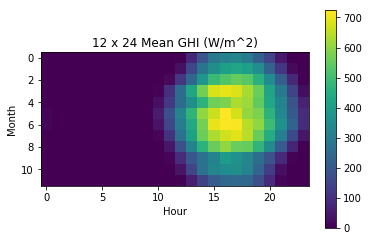

In [109]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean GHI (W/m^2)")
plt.colorbar()